# Laboratorio 1

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
from sklearn import tree
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from tabulate import tabulate


#Imports de funciones propias
import funcionesAuxiliares as fa

import warnings
# Ignora las advertencias de tipo FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)


## INTEGRANTES
- Natalie Valentina Alaniz Ferreira - CI: 5.209.018-4
- Facundo Diaz Rodriguez - CI: 5.053.849-3
- Lucio Nazareno Rodriguez - CI: 5.404.316-1

## Introducción
El objetivo es utilizar árboles de desición para generar un modelo que nos permite predecir si un estudiante va a graduarse o no.
Para ello va a utilizarse como conjunto de entrenamiento «Predict students dropout and academic success». En este caso se tomará como misma salida los valores «Enrrolled» y «Graduated» como «Graduate» y «Dropout» como «Dropout».
En este laboratorio se implementarán los árboles con una matriz que incluye una fila por nodo, donde en cada fila se guardan "node" (id), "tag" (etiqueta) "parent" (id del padre) y "children" (id de los hijos con el correspondiente)

### Análisis del conjunto de entrenamiento
El conjunto utilizado cuenta con 1420 instancias para «Dropout» y 3003 para «Graduate» con 36 atributos cada una. Por lo tanto se observa que el conjunto de entrenamiento está desbalanceado a favor de «Graduate». Esto puede generar que el modelo tenga un sesgo hacia la clase mayoritaria, por lo que se deberá tener en cuenta al momento de evaluar el modelo.

Para evaluar el modelo se utilizará la medida F1 ponderada, la cual calcula la medida F1 para ambas clases y luego genera un resultado que corresponde a la medida ponderada según la cantidad de instancias de cada clase. Esto permite tener en cuenta el desbalanceo de clases.

Así mismo se tiene en cuenta la proporción de clases en los conjuntos de entrenamiento, desarrollo y prueba. Para ello se utiliza la función train_test_split de sklearn con el parámetro stratify=Y_df_proc. Esto permite que los conjuntos generados tengan la misma proporción de clases que el conjunto original.

### Preprocesamiento
Se separará el dataset inicial en 3 subconjuntos disjuntos del mismo:
- 1 conjunto de entrenamiento (70%)
- 1 conjunto de desarrollo (15%)
- 1 conjunto de prueba (15%)
Se usa el conjunto de entrenamiento para entrenar el modelo, desarrollo para encontrar los mejores hiperparámetros y el de prueba para evaluar el modelo final.
Para el preprocesamiento se discretizan las variables continuas utilizando el método de k-means, por lo que a partir de variables continuas se obtienen variables discretas agrupandolas por clusters.

Los atributos fueron elegidos para la discretización teniendo en cuenta:
1. La descripción del dataset.
2. Observaciones del equipo con respecto a la cantidad de valores distintos que toma un atributo.
El segundo punto nos permitió identificar que pese a estar catalogados como discretos debido a su semántica y la cantidad de valores distintos que toma, se consideró una buena opción discretizarlos.

### Entrenamiento
Para el entrenamiento se utiliza el algoritmo ID3, el mismo utilizar la ganancia como método de selección del atributo por el cual continuar el árbol. En este caso se agregaron los parámetros min_samples_split y min_split_gain.
Para el cálculo de la ganancia se utiliza gain y gain ratio. El primero es el utilizado por defecto en el algoritmo ID3, mientras que el segundo es una modificación del mismo que penaliza a los atributos que tienen muchos valores distintos, ya que darle prioridad a un atributo por tener una gran cantidad de valores posibles con respecto al resto de atributos puede generar un sobreajuste al conjunto de entrenamiento.

Por ejemplo: si un atributo es una fecha y se considera discreto, darle una ventaja por la cantidad de valores distintos genera un sobreajuste porque es poco común que al evaluar una nueva instancia comparta fecha con una del conjunto de entrenamiento.
### Evaluación
Para evaluar la calidad del modelo compararemos los resultados obtenidos con los resultados de un árbol de decisión y un random forest de sklearn. Se utiliza random forest como «techo» de la performance del modelo, este modelo es más potente, ya que utiliza votación entre varios árboles.

In [124]:
corpus_df = fa.cargar_datos()
X_df_proc = fa.preprocessing_training_set(corpus_df)
Y_df_proc = X_df_proc['Target']

X_train, X_temp, y_train, y_temp = train_test_split(X_df_proc, Y_df_proc, test_size=0.3, random_state=316976, stratify=Y_df_proc)
X_devel, X_test, y_devel, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=316976, stratify=y_temp)


## Análisis previo
Inicialmente se realiza un análisis inicial para poder determinar métricas de referencia que nos permitan medir la calidad del modelo.
Para determinar el «piso» se utiliza un modelo que predice siempre la clase mayoritaria.
Se estudia el rendimiento de modelos de árboles de decisión y random forest de sklearn para poder determinar un «techo» de la performance del modelo.

In [125]:
y_df_piso = pd.DataFrame({'Target': ['Graduate'] * len(y_test)})

print(f"Accuracy del piso: {accuracy_score(y_test, y_df_piso)}")
print(f"F1 del piso: {f1_score(y_test, y_df_piso, average='weighted')}")


Accuracy del piso: 0.677710843373494
F1 del piso: 0.5475222253466289


### Prueba con DecisionTreeClassifier de sklearn

In [126]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [127]:
le = LabelEncoder()
Y_df_proc_techo = le.fit_transform(Y_df_proc)
X_df_proc_techo = X_df_proc.drop(columns=['Target'])
X_train_techo, X_temp_techo, y_train_techo, y_temp_techo = train_test_split(X_df_proc_techo, Y_df_proc_techo, test_size=0.3, random_state=3489528475, stratify=Y_df_proc_techo)
X_devel_techo, X_test_techo, y_devel_techo, y_test_techo = train_test_split(X_temp_techo, y_temp_techo, test_size=0.3, random_state=3489528475, stratify=y_temp_techo)

In [128]:
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=3489528475, min_samples_split=600)

dt_model.fit(X_train_techo, y_train_techo)
y_pred = dt_model.predict(X_test_techo)

accuracy = accuracy_score(y_test_techo, y_pred)
print(f"Accuracy del arbol de decisión: {accuracy}")

f1 = f1_score(y_test_techo, y_pred, average='weighted')
print(f"F1 del arbol de decisión: {f1}")

Accuracy del arbol de decisión: 0.849624060150376
F1 del arbol de decisión: 0.847929739513152


## Prueba con RandomForestClassifier de sklearn

In [151]:
clf = RandomForestClassifier(n_estimators=100, random_state=3489528475)
clf.fit(X_train_techo, y_train_techo)

y_pred = clf.predict(X_test_techo)

accuracy = accuracy_score(y_test_techo, y_pred)
f1 = f1_score(y_test_techo, y_pred, average='weighted')

print(f"Accuracy del RandomForest: {accuracy}")
print(f"F1 del RandomForest: {f1}")


Accuracy del RandomForest: 0.8696741854636592
F1 del RandomForest: 0.8660895738163376


## Anotaciones sobre las funciones definidas en el archivo auxiliar
**evaluate_instance(instance, tree)**: Se puede dar que alguno de los posibles valores de un atributo no se encuentre en el conjunto de entrenamiento. En ese caso, se debe seguir el camino por el nodo que más se parezca en cuanto a distancias al valor del atributo. Por ejemplo, si la instancia que busco clasificar tiene en el atributo "Previous qualification (grade)" como posibles valores 1, 2 y 3, pero en el conjunto de entrenamiento no hay ninguna instancia con el valor 1 asignado, entonces se debe continuar con el recorrido del por la rama con valor 2.

Se incluye en la definicion de la funcion ID3 el parametro use_gain_function, el cual permite elegir entre utilizar la ganancia o el gain ratio como criterio de selección de atributos.
Dado que el dataset se encuentra desbalanceado, se espera que el gain ratio sea una mejor opción que la ganancia, ya que el gain ratio penaliza a los atributos que tienen muchos valores distintos, lo cual puede generar un sobreajuste al conjunto de entrenamiento.

## Entrenamiento inicial

In [129]:
arbol_gain = []
arbol_gain_ratio = []

fa.ID3(arbol_gain, -1, X_train, y_train, None, 0, 0, False)
fa.ID3(arbol_gain_ratio, -1, X_train, y_train, None, 0, 0, True)

In [130]:
res = fa.evaluate_dataset(X_devel, arbol_gain)
print(f"Accuracy del arbol con gain: {accuracy_score(y_devel, res)}")

res = fa.evaluate_dataset(X_devel, arbol_gain_ratio)
print(f"Accuracy del arbol con gain ratio: {accuracy_score(y_devel, res)}")


Accuracy del arbol con gain: 0.8042168674698795
Accuracy del arbol con gain ratio: 0.8117469879518072


## Modificación del arbol según los hiperparámetros

## Hiperparámetros iniciales
En primer lugar, se obtiene el valor máximo de las ganancias iniciales de los atributos para la seed determinada del conjunto de entrenamiento, ya que de ser mayor al mismo el resultado sería un arbol con un solo nodo.
### Valores máximos de los hiperparámetros
#### min_split_gain
- min_split_gain para gain: 0.3114026674723257
- min_split_gain para gain ratio: 0.23869317677342747

Los valores a probar serán, por lo tanto:
- 0 <= min_split_gain <= 0.3114026674723257 para gain
- 0 <= min_split_gain <= 0.23869317677342747 para gain ratio

En la siguiente celda se puede observar como en caso de elegir un valor mayor al máximo, el resultado es un arbol con un solo nodo, prediciendo así sólo la clase mayoritaria.

**Nota**: Que la ganancia máxima sea esa para la seed utilizada no significa que sea la misma para todos los casos, pero es una métrica que tomamos como referencia para hacernos una idea de la magnitud del hiperparámetro.

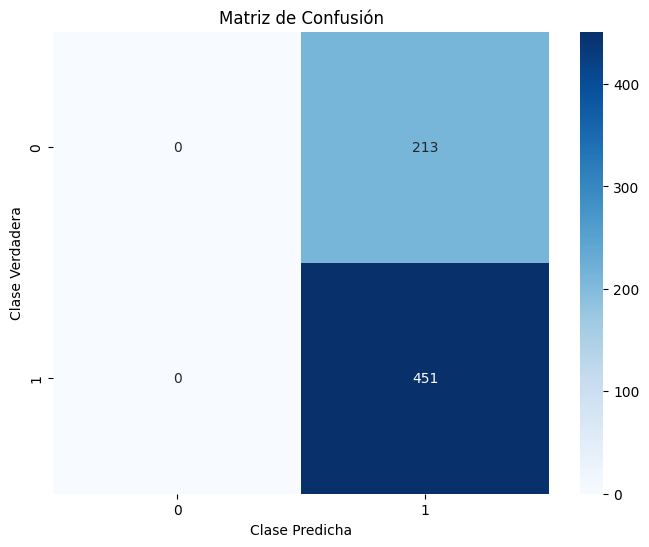

In [131]:
arbol_min_gain_max = []
fa.ID3(arbol_min_gain_max, -1, X_train, y_train, None, 0, 0.24 , True)
res = fa.evaluate_dataset(X_devel, arbol_min_gain_max)
fa.get_confusion_matrix(y_devel, res)

#### min_samples_split


In [132]:
def tree_develop(min_samples_split_max, min_split_gain_max, gain_speed, samples_speed, min_samples_split, min_split_gain, use_gain_ratio):
    arbol = []
    results = []
    samples_split = min_samples_split
    split_gain = min_split_gain

    while samples_split <= min_samples_split_max:
        while split_gain <= min_split_gain_max:
            fa.ID3(arbol, -1, X_train, y_train, None, samples_split, split_gain, use_gain_ratio)
            res = fa.evaluate_dataset(X_devel, arbol)
            results.append([samples_split, split_gain, accuracy_score(y_devel, res), f1_score(y_devel, res, average='weighted')])
            split_gain += gain_speed
            arbol = []
        samples_split += samples_speed
        split_gain = min_split_gain


    return results

In [133]:
resultados_gain = tree_develop(3500, 0.4, 0.1, 500,0, 0, False)
resultados_gain_ratio = tree_develop(3500, 0.31, 0.1,500, 0, 0, True)

In [134]:
def get_heatmap(results, titulo):
    df = pd.DataFrame()

    for sample_split, split_gain, _, f1 in results:
        df.loc[split_gain, sample_split] = f1

    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".4f")
    plt.title(titulo)
    plt.xlabel('min_samples_split')
    plt.ylabel('min_split_gain')
    plt.show()

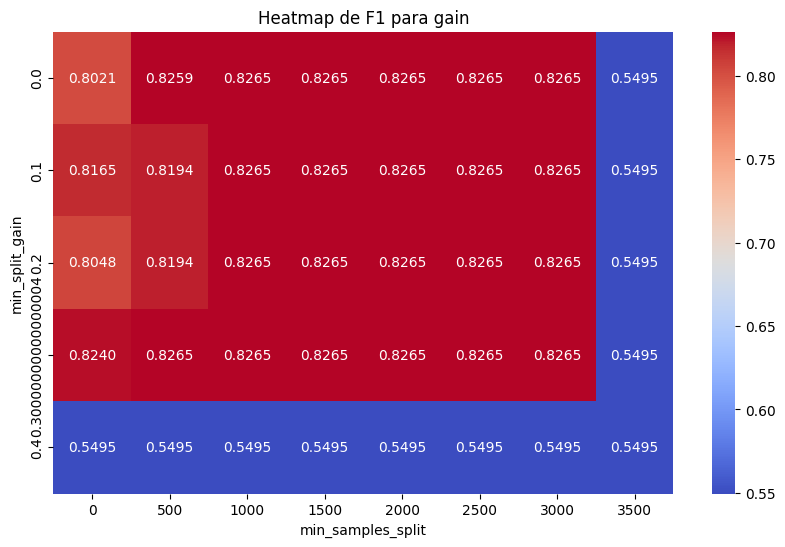

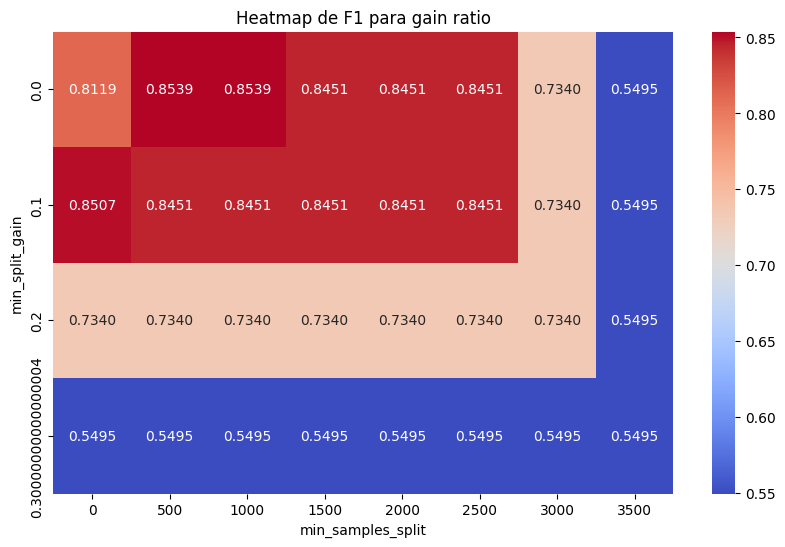

In [135]:
get_heatmap(resultados_gain, 'Heatmap de F1 para gain')
get_heatmap(resultados_gain_ratio, 'Heatmap de F1 para gain ratio')

## Análisis de los Heatmaps
Se puede observar que para ambos casos a al eliminar una cantidad mayor al tamaño del conjunto de entrenamiento genera un único nodo, el árbol predice la clase mayoritaria del conjunto de entrenamiento.
Además, como se mencionó anteriormente si el valor de min_split_gain es mayor al máximo de ganancia para la seed utilizada, el resultado es un árbol con un solo nodo, prediciendo así solo la clase mayoritaria.

### Implementación usando gain
Se observa que en este caso que a partir de un min_sample_split de 1000, la ganancia no afecta al valor final. Esto nos lleva a pensar que el arbol generado es el mismo por lo que no es necesario continuar con la búsqueda para valores entre 1000 y 3000.
Este resultado es coherente porque es un porcentaje elevado del conjunto de entrenamiento.

### Implementación usando gain ratio
Se observa un fenomeno similar que en el caso de la implemenatación con gain, para valores de min_sample_split mayores a 3000.
De forma análoga valores de min_split_gain mayores a 0.2 demuestran ser lo suficientemente granades como para generar un arbol con una cantidad de nodos insuficiente como para representar adecuadamente la realidad.

A continuación se continuan probando con los valores focalizados en la implementación con gain ratio, dentro de la región con mejores resultados.


In [136]:
resultados = tree_develop(1000, 0.1, 0.01,100, 500, 0, True)

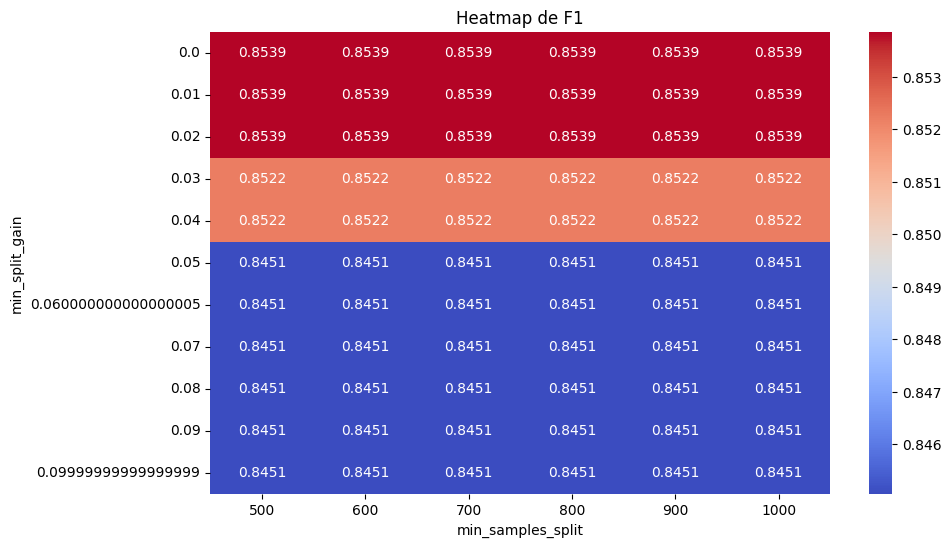

In [137]:
get_heatmap(resultados, 'Heatmap de F1')

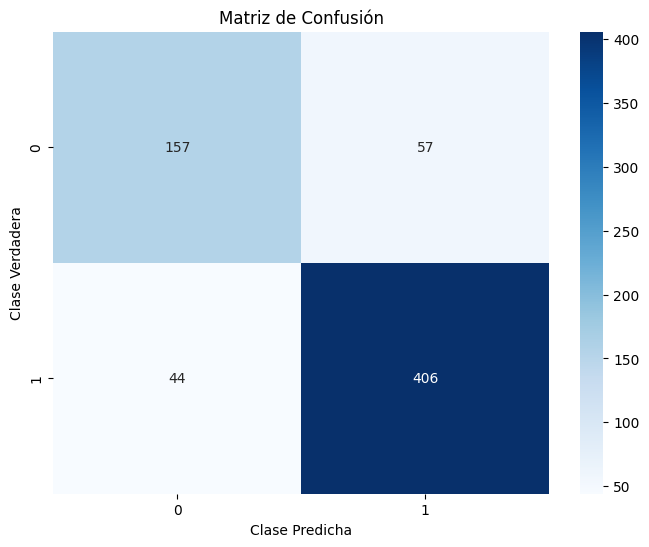

In [144]:
# Matriz de confusión para los hiperparámetros con mejor F1 en X_devel evaluado en X_test
arbol = []
fa.ID3(arbol, -1, X_train, y_train, None, 600, 0.02, True)
res = fa.evaluate_dataset(X_test, arbol)
fa.get_confusion_matrix(y_test, res)

## Validación cruzada
A pesar de tener resultados prometedores en el heatmap, todavía es necesario verificar que los resultados sean consistentes para distintas distribuciones del conjunto de entrenamiento. Esto es necesario, ya que por una cuestión de azar pudimos haber tenido unos resultados que no sean representativos del verdadero funcionamiento del modelo.

Para ello se realiza validación cruzada:

In [145]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score

In [146]:
# Validación cruzada
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=316976)

In [147]:
# Entrenamiento
def validacion_cruzada():
    arbol = []
    results = []
    for train_index, test_index in kf.split(X_df_proc, Y_df_proc):
        X_train, X_test = X_df_proc.iloc[train_index], X_df_proc.iloc[test_index]
        y_train, y_test = Y_df_proc.iloc[train_index], Y_df_proc.iloc[test_index]
        fa.ID3(arbol, -1, X_train, y_train, None, 600, 0.03, True)
        res = fa.evaluate_dataset(X_test, arbol)
        results.append([accuracy_score(y_test, res), f1_score(y_test, res, average='weighted')])
        arbol = []
    return results

In [148]:
resultados = validacion_cruzada()
headers = ["Accuracy", "F1"]
print(tabulate(resultados, headers=headers, tablefmt="fancy_grid"))
# average
print(f"Accuracy promedio: {np.mean([x[0] for x in resultados])}")
print(f"F1 promedio: {np.mean([x[1] for x in resultados])}")


╒════════════╤══════════╕
│   Accuracy │       F1 │
╞════════════╪══════════╡
│   0.825989 │ 0.82201  │
├────────────┼──────────┤
│   0.849718 │ 0.847618 │
├────────────┼──────────┤
│   0.845198 │ 0.844213 │
├────────────┼──────────┤
│   0.842938 │ 0.839015 │
├────────────┼──────────┤
│   0.86991  │ 0.865967 │
╘════════════╧══════════╛
Accuracy promedio: 0.8467502620344096
F1 promedio: 0.8437645472481096


## Mejoras a futuro

### Mejoras en el preprocesamiento
- Se puede explorar la posibilidad de descartar atributos menos relevantes que puedan estar introduciendo ruido al conjunto de entrenamiento.

### Posibles hiperparametros a probar
- Cantidad máxima de nodos del árbol.
- Produndidad máxima del árbol generado.
- Cambiar el tipo de discretizador (ej: uniform, quantile, kmeans).
- Para las variables continuas considerar el número de clusters como hiperparámetro.

### Mejoras en el dataset
Sería deseable tener un dataset balanceado, para lograr esto algunas opciones son:
- Eliminar instancias de la clase mayoritaria.
- Generar instancias de la clase minoritaria a partir de instancias del conjunto de entrenamiento.
- Utilizar un método que permita asignar pesos a las clases continuando con la idea de usar la medida F1 weighted.

## Conclusiones
Comparando los resultados obtenidos con el rendimiento del piso definido anteriormente, se observa que el modelo tiene un comportamiento superior al piso, lo cual es esperable ya que el piso es un modelo muy simple que predice siempre la clase mayoritaria.
Al compararlo con el techo (random forest) a pesar de que el modelo tiene un rendimiento ligeramente inferior, es un resultado esperable, porque el mismo utiliza votación entre varios árboles, lo que le permite tener una mayor capacidad de generalización.
A su vez el resultado es similar al obtenido con random tree de sklearn, siendo nuestro modelo con un rendimiento levemente mejor, esto probablemente se debe a que no se ajustaron los hiperparametros del modelo de sklearn (se utilizan los valores por defecto).

